# Installing and importing dependencies

In [1]:
!pip install openpyxl
!pip install pandas
!pip install numpy
!pip install rdkit

In [74]:
import pandas as pd
import numpy as np
import time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import History 



import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#plt.style.use(['science'])
%matplotlib inline
sns.set_theme()
#plt.style.use([])
#plt.style.use(['science','ieee'])

Function that will be used to check that no "na" values appear:

In [4]:
def check_no_na(data):
    if data.isna().sum().eq(0).all():
        print("Success: No NA values found.")
        return
    print("Warning: NA values found.")

Function to build a joint plot:

In [5]:
def plot_joint(y_pred, height=7, name="MODEL"):
    plot = sns.JointGrid(x=y_pred, y=y_test, height=height);
    plot.plot_joint(sns.scatterplot, s=100, color='slateblue')
    plot.plot_marginals(sns.kdeplot, color='slateblue', fill=True)

    x_eq_y=np.arange(np.array(plt.axis()).min(), np.array(plt.axis()).max())

    plot.ax_joint.plot(x_eq_y, x_eq_y, 'k', linewidth = 2, linestyle='--')
    
    plot.ax_joint.set_xlabel("y predicted")
    plot.ax_joint.set_ylabel("y target")
    plot.fig.suptitle(f"target vs predicted Output for the {name} model", y=1.01)
    return plot

# Importing the dataset

In [6]:
df_raw=pd.read_excel("denmark.xlsx")
df_raw.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1C,3.134625
1,O=P1(O)OC2=C(C3=CC(C4=C(C)C=C(C)C=C4C)=CC(C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=C(OC)C=C1,1.531803
2,O=P1(O)OC2=C(C3=CC=C(OC)C=C3)C=C4C(C=CC=C4)=C2...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1,1.074991
3,O=P1(O)OC2=[C@]([C@]3=C(Cl)C=C(Cl)C=C3Cl)C=C4C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=CC=C1C,1.334823
4,O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1=CC=CC=C1,1.743658


# Looking at the data

### Target values

First of all, it would be important to look at how output values are distributed:

In [7]:
df_raw.describe()

,Output
count,1075.000000
mean,0.987658
std,0.700524
min,-0.419378
25%,0.473820
50%,1.050757
75%,1.370104
max,3.134625


One could also look at the distribution of the target variable:

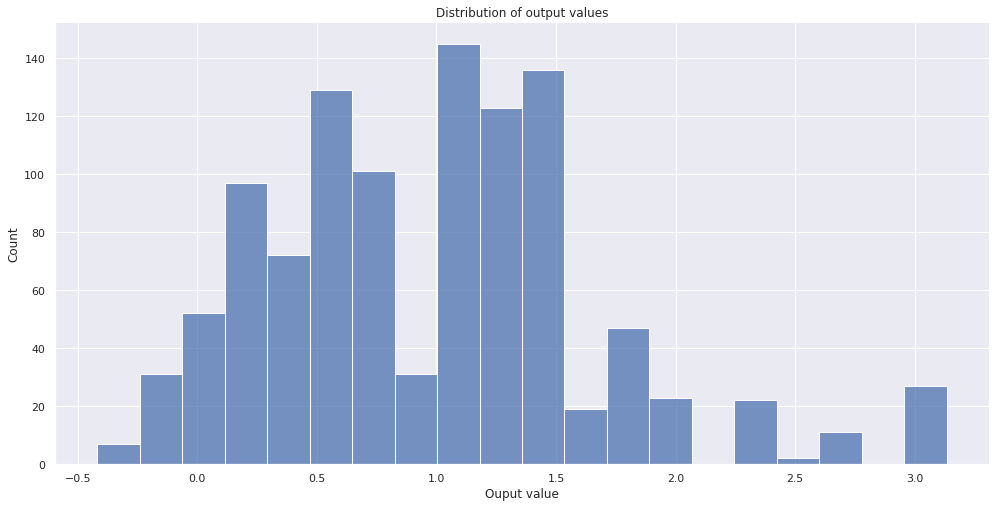

In [8]:
sns.displot(x=df_raw["Output"], bins=20, height=7, aspect=2)
plt.title("Distribution of output values")
plt.xlabel("Ouput value")
plt.show()

The target variable looks to be roughly in the same magnitude and has an approximate gaussian distribution (with a slight tail), which is a good sign as this means that no further transformation is required for it.

### Features

Are there any "na" values?

In [9]:
check_no_na(df_raw)

Success: No NA values found.


How many different molecules are there?

In [10]:
unique_catalysts=df_raw["Catalyst"].unique()
unique_imines=df_raw["Imine"].unique()
unique_thiols=df_raw["Thiol"].unique()
pd.DataFrame({"Unique Catalysts": [unique_catalysts.shape[0]], "Unique Imines": [unique_imines.shape[0]], "Unique Thiols": [unique_thiols.shape[0]]})

,Unique Catalysts,Unique Imines,Unique Thiols
0,43,5,5


Here, one could use One-hot encoding for the Imines and Thiols. This idea was discarded since in the case another Thiol or Imine is added, one would have to retrain the model instead of being able to fine-tune it. 

Show 3 random different Catalysts:

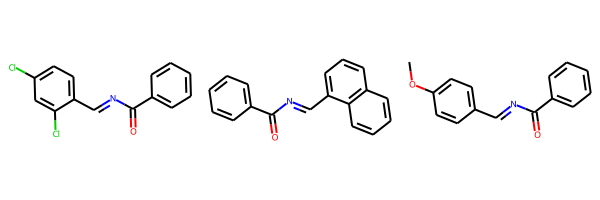

In [11]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Imine:

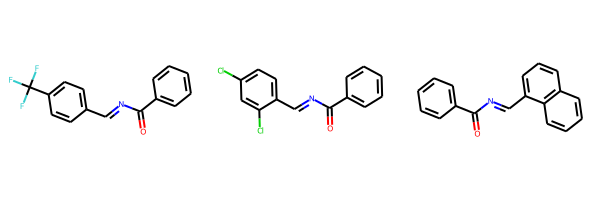

In [12]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Thiol:

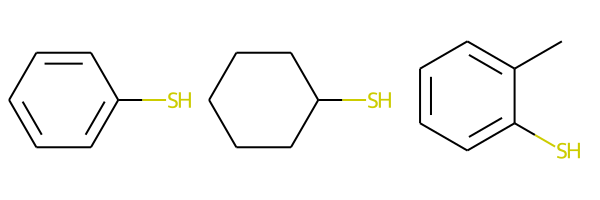

In [13]:
mol_list=[]
unique_molecules=df_raw["Thiol"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules, index)
Draw.MolsToGridImage(mol_list)

# Preprocessing

### Creating RDKit molecules

Translating the "Catalyst", the "Imine" and the "Thiol" columns from SMILES to a RDKit molecule:

In [14]:
df_X=df_raw[["Catalyst", "Imine", "Thiol"]].applymap(Chem.MolFromSmiles)
df_y=df_raw["Output"]
df_X.head()

,Catalyst,Imine,Thiol
0,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138df0>,<rdkit.Chem.rdchem.Mol object at 0x7f72c92ad170>,<rdkit.Chem.rdchem.Mol object at 0x7f72c11507b0>
1,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138b70>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138b20>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1150710>
2,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138e40>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138c60>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1165e90>
3,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138e90>,<rdkit.Chem.rdchem.Mol object at 0x7f72c11506c0>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1165e40>
4,<rdkit.Chem.rdchem.Mol object at 0x7f72c1138ee0>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1150670>,<rdkit.Chem.rdchem.Mol object at 0x7f72c1165df0>


Verifying that all the smiles transfered successfuly. The RDKit documentaton states:

>or None on failure:
>
>> ```m = Chem.MolFromMolFile('data/invalid.mol')```
>>
>> ```m is None```
>
>True

So the "na" instances are counted and should be 0 if no problems were encountered:

In [15]:
check_no_na(df_X)

Success: No NA values found.


The train/test ratio was chosen arbitrarily. This could eventually be added as a hyperparameter to find an optimum as has been done [here](https://www.sciencedirect.com/science/article/pii/S2451929420300851). 

In [16]:
X_train, X_test, y_train, y_test=train_test_split(df_X.to_numpy(), df_y.to_numpy(), train_size=0.75)

For later on, Morgan fingerprints will be used. In order to try and search for the best parameters for these molecules, the atom radius and the number of bits used will be searched using grid search.

Late addition. This will take out the morgan fingerprints parameters from the models if the (until now) found hyperparameters are not too 

### Pipeline

Here, in order to later use SKlearn's ```CVGridSearch```, a custom pipeline will be built in order to be able to find the ideal hyperparameters. First step: creating a custom transformer to be used in the pipeline, in order to use RDKit's ```GetMorganFingerprint```'s parameters as hyperparameters for the model.

ridge_search.best_estimator_A similar pipeline template will be used for later trials, using the same functions. Although it is intuitive to assume that the same fingerprint parameters should be used for every model, the ```n_bits``` and the ```n_atom``` hyperparameters should be computed in order to verify that this hypothesis holds for different models.

Personal note: As this is the first time I work with molecules, my first thought was to build a simple ridge regressor and try to give it a morgan fingerprint as input. This is probably not viable since the number of parameters used is too great. Later on, the idea would be to add descriptors into the features, potentially using TF's functional API.

In [17]:
def morgan_fp(X, n_bits, n_atom):
    """Returns numpy array with bits from morgan fingerprint"""
    fp=AllChem.GetMorganFingerprintAsBitVect(X,int(n_atom), nBits=int(n_bits))
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

class fingerprinter(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits # int necessary, otherwise rdkit c++ library doesn't play along
        self.n_atom = n_atom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        new_X=np.array([])
        for row in X:
            new_row=np.array([])
            for element in row:
                fp=morgan_fp(element, self.n_bits, self.n_atom)
                new_row=np.append(new_row, fp, 0)
            #new_row=new_row.reshape((df_X.shape[1],-1))
            new_X=np.append(new_X, new_row)
            new_X=new_X.reshape([-1, new_row.shape[0]])
        return new_X
#fingerprinter([2,3,4][0], np.linspace(1000, 5000, 10, dtype=int)[0]).transform(X_train)

Now, the first pipeline can be created:

In [18]:
pipe = Pipeline([( "fingerprinter" , fingerprinter()),
                       ("ridge",Ridge())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [19]:
#param_grid={"fingerprinter__n_bits":np.logspace(3, 4, 10, dtype=int), "fingerprinter__n_atom":np.arange(1, 4, 1), "ridge__alpha":np.logspace(0, 2, 4)}
#param_grid={"fingerprinter__n_bits": np.linspace(1000, 5000, 10, dtype=int), "fingerprinter__n_atom":np.array([2, 3, 4]), "ridge__alpha":np.logspace(-3, 1, 5)}
param_grid={"fingerprinter__n_bits": np.linspace(1500, 3000, 10, dtype=int), "fingerprinter__n_atom":np.array([2,3,4]), "ridge__alpha":np.logspace(-3, 3, 10)}
param_grid

{'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
 'fingerprinter__n_atom': array([2, 3, 4]),
 'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

The train/test ratio was chosen arbitrarily. This could eventually be added as a hyperparameter to find an optimum as has been done [here](https://www.sciencedirect.com/science/article/pii/S2451929420300851). 

In [20]:
X_train, X_test, y_train, y_test=train_test_split(df_X.to_numpy(), df_y.to_numpy(), train_size=0.75)

The default cross-validation of 5-fold were chosen, as the available computational power is relatively low.

### Fitting

In [21]:
ridge_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)
ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


KeyboardInterrupt: 

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",ridge_search.best_estimator_)
print("\n The best TRAIN score (R^2) across ALL searched params:\n",ridge_search.best_score_)
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(ridge_search.best_estimator_.predict(X_test), y_test))
print("\n The TEST MSE of the best estimator:\n",mean_squared_error(ridge_search.best_estimator_.predict(X_test), y_test))
print("\n The best parameters across ALL searched params:\n",ridge_search.best_params_)

In [ ]:
ridge_search.best_params_

Looking at the relative distributions of the predicted output vs the target output: 

In [ ]:
plot_joint(ridge_search.best_estimator_.predict(X_test), name="Ridge");

# Ridge regression

Ridge was chosen instead of linear regression in order to avoid overfitting the model. A linear regression with only the morgan fingerprint parameters to optimize with ```GridSearchCV``` could be considered, removing the need to optimize for morgan fingerprints. Nevertheless, This would be a good addition for the future. One detail that could cause problems is that a bigger fingerprint will be prefered, with only marginally better results but a significantly worse performance.

### Pipeline

Here, in order to later use SKlearn's ```CVGridSearch```, a custom pipeline will be built in order to be able to find the ideal hyperparameters. First step: creating a custom transformer to be used in the pipeline, in order to use RDKit's ```GetMorganFingerprint```'s parameters as hyperparameters for the model.

ridge_search.best_estimator_A similar pipeline template will be used for later trials, using the same functions. Although it is intuitive to assume that the same fingerprint parameters should be used for every model, the ```n_bits``` and the ```n_atom``` hyperparameters should be computed in order to verify that this hypothesis holds for different models.

Personal note: As this is the first time I work with molecules, my first thought was to build a simple ridge regressor and try to give it a morgan fingerprint as input. This is probably not viable since the number of parameters used is too great. Later on, the idea would be to add descriptors into the features, potentially using TF's functional API.

In [22]:
def morgan_fp(X, n_bits, n_atom):
    """Returns numpy array with bits from morgan fingerprint"""
    fp=AllChem.GetMorganFingerprintAsBitVect(X,int(n_atom), nBits=int(n_bits))
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

class fingerprinter(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits # int necessary, otherwise rdkit c++ library doesn't play along
        self.n_atom = n_atom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        new_X=np.array([])
        for row in X:
            new_row=np.array([])
            for element in row:
                fp=morgan_fp(element, self.n_bits, self.n_atom)
                new_row=np.append(new_row, fp, 0)
            #new_row=new_row.reshape((df_X.shape[1],-1))
            new_X=np.append(new_X, new_row)
            new_X=new_X.reshape([-1, new_row.shape[0]])
        return new_X
#fingerprinter([2,3,4][0], np.linspace(1000, 5000, 10, dtype=int)[0]).transform(X_train)

Now, the first pipeline can be created:

In [23]:
pipe = Pipeline([( "fingerprinter" , fingerprinter()),
                       ("ridge",Ridge())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [24]:
#param_grid={"fingerprinter__n_bits":np.logspace(3, 4, 10, dtype=int), "fingerprinter__n_atom":np.arange(1, 4, 1), "ridge__alpha":np.logspace(0, 2, 4)}
#param_grid={"fingerprinter__n_bits": np.linspace(1000, 5000, 10, dtype=int), "fingerprinter__n_atom":np.array([2, 3, 4]), "ridge__alpha":np.logspace(-3, 1, 5)}
param_grid={"fingerprinter__n_bits": np.linspace(1500, 3000, 10, dtype=int), "fingerprinter__n_atom":np.array([2,3,4]), "ridge__alpha":np.logspace(-3, 3, 10)}
param_grid

{'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
 'fingerprinter__n_atom': array([2, 3, 4]),
 'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

The default cross-validation of 5-fold were chosen, as the available computational power is relatively low.

### Fitting

In [25]:
ridge_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

ridge_search.fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
--- 1674.523609161377 seconds ---


In [26]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",ridge_search.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",ridge_search.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",ridge_search.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(ridge_search.best_estimator_.predict(X_test), y_test))
print("\n The TEST MSE of the best estimator:\n",mean_squared_error(ridge_search.best_estimator_.predict(X_test), y_test))
print("\n The best parameters:\n",ridge_search.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('fingerprinter', fingerprinter(n_bits=1666)),
                ('ridge', Ridge(alpha=10.0))])

 The best mean TRAIN score (R^2):
 0.8388925147589729

 The best STD of TRAIN score (R^2):
 0.016831471665377167

 The TEST MAE of the best estimator:
 0.18485517302609014

 The TEST MSE of the best estimator:
 0.0640390030825687

 The best parameters:
 {'fingerprinter__n_atom': 2, 'fingerprinter__n_bits': 1666, 'ridge__alpha': 10.0}


In [27]:
ridge_search.best_params_

{'fingerprinter__n_atom': 2,
 'fingerprinter__n_bits': 1666,
 'ridge__alpha': 10.0}

Looking at the relative distributions of the predicted output vs the target output: 

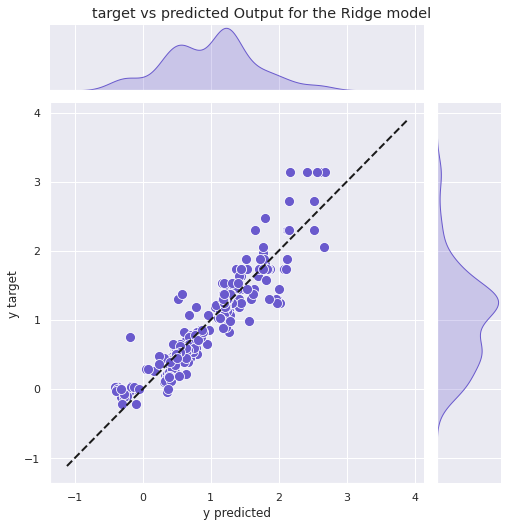

In [28]:
plot_joint(ridge_search.best_estimator_.predict(X_test), name="Ridge");

In order to streamline the process, the fingerprint with the parameters as found above before will be used:

In [29]:
f=lambda x: fingerprinter(n_bits=ridge_search.best_params_["fingerprinter__n_bits"], n_atom=ridge_search.best_params_["fingerprinter__n_atom"]).transform(x)
X_train_fp, X_test_fp=f(X_train), f(X_test)

In [30]:
X_test_fp.shape

(269, 4998)

# Random Forest Regression

Same as before, this time with a random forest regressor. Because of the limited computational power, only the n_estimators will be considered along with XXXXXXX, the morgan fingerprints marameters will not be changed as it is suspected that they would probably only get bigger as stated before. The fingerprint parameters are optimized again because of the fear that the ridge regressor punished bigger fingerprints (more added weights, even small, can be punished. Note the big alpha parameter):

### Pipeline

In [31]:
pipe = Pipeline([("forest",RandomForestRegressor())])

The number of tested parameters have been significantly reduced (Lack of computational power)

In [32]:
param_grid={"forest__max_depth": np.linspace(50, 1500, 15,  dtype=int)}
param_grid

{'forest__max_depth': array([  50,  153,  257,  360,  464,  567,  671,  775,  878,  982, 1085,
        1189, 1292, 1396, 1500])}

### Fitting

In [ ]:
forest_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

forest_search.fit(X_train_fp, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
--- 54.103111267089844 seconds ---


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",forest_search.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",forest_search.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",forest_search.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(forest_search.best_estimator_.predict(X_test_fp), y_test))
print("\n The TEST MSE of the best estimator:\n",mean_squared_error(forest_search.best_estimator_.predict(X_test_fp), y_test))
print("\n The best parameters:\n",forest_search.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('forest', RandomForestRegressor(max_depth=982))])

 The best mean TRAIN score (R^2):
 0.9022393716477305

 The best STD of TRAIN score (R^2):
 0.013991828519526042

 The TEST MAE of the best estimator:
 0.132209648672342

 The TEST MSE of the best estimator:
 0.03967762511427032

 The best parameters:
 {'forest__max_depth': 982}


In [ ]:
forest_search.best_params_

{'forest__max_depth': 982}

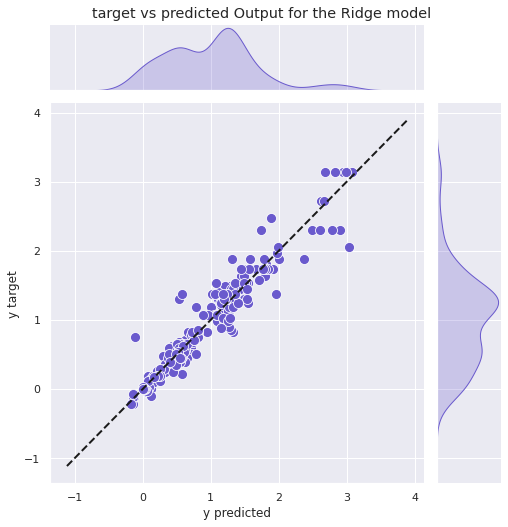

In [ ]:
plot_joint(forest_search.best_estimator_.predict(X_test_), name="Ridge");

# Neural network

Here, the number of layers  will be fixed and the focus will be on the dropout rate and the number of perceptrons per layer. This was done because of the limited computational power and the architecture of the model should definitively be studied in more details:

In [150]:
def create_model(optimizer='Adam',
                 dropout=0.2, n_perceptrons=64, summary=True):
    inputs = keras.Input(shape=(ridge_search.best_params_["fingerprinter__n_bits"]*3,))
    
    dense = layers.Dense(n_perceptrons, activation="relu")
    x1 = dense(inputs)
    
    dropout1 = Dropout(dropout)(x1)
    
    dense = layers.Dense(n_perceptrons, activation="relu")
    x2 = dense(dropout1)
    
    dropout2 = Dropout(dropout)(x2)
    
    dense = layers.Dense(1)
    outputs = dense(dropout2)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="simple_MLP")
    if summary:
        model.summary()
    
    model.compile(loss=keras.losses.MSE,optimizer=optimizer)

    return model

In order to use the same methodology as before, the cross validation has to be done manually. A monitor has been added to stop if the model is not learning anymore, to avoid overfitting. There is another validation split in the TF model to help stopping early if the improvement in each epoch is too small:

In [169]:
def CV_NN(n_split=5, dropout=0.2, n_perceptrons=64):
    """cross validation for grid search with NN"""
    CV_MSE=np.array([])
    
    for train_index,test_index in KFold(n_split).split(X_train_fp):
        monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-2, patience=1)
        
        X_train_split,X_test_split=X_train_fp[train_index],X_train_fp[test_index]
        y_train_split,y_test_split=y_train[train_index],y_train[test_index]

        model=create_model(summary=False, dropout=dropout, n_perceptrons=n_perceptrons)
        model.fit(X_train_split.reshape([-1, ridge_search.best_params_["fingerprinter__n_bits"]*3]), y_train_split, callbacks =[monitor], epochs=100, validation_split=0.25)

        CV_MSE=np.append(CV_MSE, mean_squared_error(model.predict(X_test_split),y_test_split))
    return CV_MSE

The parameters should be independent of each other, which is why they can be found independently:

In [174]:
dropout_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
n_perceptrons_list=[32, 64, 128, 256]

best_loss=10e10
for dropout in dropout_list:
    loss=CV_NN(dropout=dropout).mean()
    if loss<best_loss:
        best_loss=loss
        best_dropout=dropout

best_loss=10e10
for n_perceptrons in n_perceptrons_list:
    loss=CV_NN(n_perceptrons=n_perceptrons).mean()
    if loss<best_loss:
        best_loss=loss
        best_n_perceptrons=n_perceptrons


Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 0.7124 - val_loss: 0.2034
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1595 - val_loss: 0.0924
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0648
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0631 - val_loss: 0.0521
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0460
Epoch 1/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9570 - val_loss: 0.2278
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2293 - val_loss: 0.1120
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0988 - val_loss: 0.0731
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0643 - val_loss: 0.0644
Epoch 1/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9085 - val_loss: 0.2417
Epoch 2/10

In [175]:
best_dropout,best_n_perceptrons

(0, 128, 0.06624059561954868)

A model can now be built with the best parameters found above:

In [176]:
model=create_model(summary=True, dropout=best_dropout, n_perceptrons=best_n_perceptrons)
model.fit(X_train_split.reshape([-1, ridge_search.best_params_["fingerprinter__n_bits"]*3]), y_train_split, callbacks =[monitor], epochs=100, validation_split=0.25)

Model: "simple_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_682 (InputLayer)       [(None, 4998)]            0         
_________________________________________________________________
dense_2038 (Dense)           (None, 128)               639872    
_________________________________________________________________
dropout_1272 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_2039 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1273 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_2040 (Dense)           (None, 1)                 129       
Total params: 656,513
Trainable params: 656,513
Non-trainable params: 0
__________________________________________________

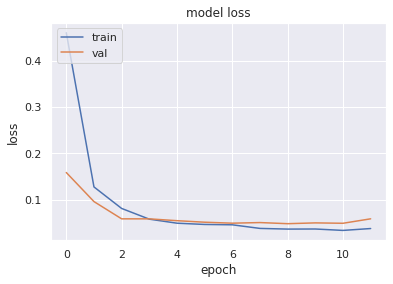

In [177]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [178]:
mean_squared_error(model.predict(X_test),y_test)

0.048170710247184556

Alternative: use qsar fingerprints: http://www.qsar4u.com/files/qsar_rdkit_tutorial/qsar-rdkit.html

Alternative to consider: https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616

Why the morgan fingerprint? The litterature does not seem to agree but they seem to lean towards that fingerprint: http://practicalcheminformatics.blogspot.com/2020/03/benchmarking-one-molecular-fingerprint.html

Personal notes: Iterations:
1. Tried to compute morgan fingerprint and take that output to compute a ridge regression. This would have been the simplest and most naive iteration. Initially a failure, I ended up being able to fine tune it more or less. Due to the high cost of the computations I did not fine-tune the hyperparameters too much.
2. Random forest regression. I realized here that the morgan fingerprint parameters would be optimizable from a simple linear regression and could then be discarded as a hyperparameter. If time allows it, This will get changed, but I would like to continue building some models and a good way of comparing them before. 

For the bootstrapping: sample size has to be extremely small, otherwise it does the take too much time (>7h...). Is pretty useless like this. In case of trying again: https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.cross_validation.Bootstrap.html